In [1]:
!pip install -qU langchain
!pip install -qU openai
!pip install -qU cohere
!pip install -qU faiss-cpu
!pip install -qU tiktoken
!pip install -qU pypdf
!pip install -qU sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.4/246.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 892.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

In [3]:
import os
import openai
from getpass import getpass

In [4]:
os.environ["COHERE_API_KEY"] = getpass("Cohere API Key:")

Cohere API Key:··········


In [5]:
os.environ["OPENAI_API_KEY"] = getpass("openai API Key:")

openai API Key:··········


In [6]:
pdf_folder_path = "/content/drive/MyDrive/10academy/contract rag/raptor_data"
loader = PyPDFDirectoryLoader(pdf_folder_path)
docs = loader.load()
#
print(len(docs))
#
print(docs[1].page_content)

73
TABLE
OF
CONTENTS
ARTICLE
I
DEFINITIONS;
CER TAIN
RULES
OF
CONSTRUCTION
2
Section
1.01
Definitions
2
Section
1.02
Certain
Matters
of
Construction
13
ARTICLE
II
PURCHASE
AND
SALE
OF
SHARES
AND
WARRANTS;
TREA TMENT 
OF
OPTIONS;
CLOSING.
14
Section
2.01
Purchase
and
Sale
of
Shares
14
Section
2.02
Purchase
Price
14
Section
2.03
The
Closing
14
Section
2.04
Closing
Payments.
15
Section
2.05
Closing
Deliveries
15
Section
2.06
Treatment
of
Options
16
Section
2.07
Purchase
Price
Adjustment
17
Section
2.08
Escrow
19
ARTICLE
III
REPRESENT ATIONS
AND
WARRANTIES
REGARDING
THE 
ACQUIRED
COMP ANIES.
19
Section
3.01
Organization
19
Section
3.02
Power
and
Authorization
20
Section
3.03
Authorization
of
Governmental
Authorities
20
Section
3.04
Noncontravention
20
Section
3.05
Capitalization
of
the
Acquired
Companies
21
Section
3.06
Financial
Matters
22
Section
3.07
Absence
of
Certain
Developments
22
Section
3.08
Debt;
Guarantees
24
Section
3.09
Assets
25
Section
3.10
Real
Property
25
Section
3.11
Inte

In [7]:
#initializing the recursive chunker
text_chunker = RecursiveCharacterTextSplitter(
    chunk_size = 512,
    chunk_overlap = 64,
    length_function = len,
)

In [8]:
#chunking the data
chunks = text_chunker.split_documents(docs)
print(len(chunks))

526


In [9]:
model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'},
    encode_kwargs=encode_kwargs
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

In [11]:
query = "How much is the escrow amaount?"
docs = retriever.get_relevant_documents(query)
print(docs)

[Document(page_content='gains\nof\nsuch\nPerson\n(including\nstock\nappreciation,\nphantom\nstock,\nprofit\nparticipation\nor\nother \nsimilar\nrights).\n“\nEscrow\nAmount\n”\nmeans,\n$1,000,000\n“\nFacilities\n”\nmeans\nany\nbuildings,\nplants,\nimprovements\nor\nstructures\nlocated\non\nthe\nReal \nProperty .\n“\nFamily\nMember\n”\nmeans,\nwith\nrespect\nto\nany\nindividual,\n(a) such\nPerson’ s\nspouse,\n(b) \neach\nparent,\nbrother ,\nsister\nor\nchild\nof\nsuch\nPerson\nor\nsuch\nPerson’ s\nspouse,\n(c) the\nspouse\nof\nany \nPerson\ndescribed\nin\nclause\n(b)\nabove,\n(d) each\nchild\nof\nany\nPerson', metadata={'source': '/content/drive/MyDrive/10academy/contract rag/raptor_data/Copy of Raptor Contract.docx.pdf', 'page': 10}), Document(page_content='in\naccordance\nwith\nthe\nterms\nof \nthe\nEscrow\nAgreement).\nSection\nI.04\nEscrow\n.\n(a)\nAt\nClosing,\nBuyer\nwill\ndeposit\nthe\nEscrow\nAmount\nin\nescrow\non\nbehalf\nof\nthe \nSellers\nin\naccordance\nwith\nthe\nEscrow\nAg

In [12]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

pretty_print_docs(docs)

Document 1:

gains
of
such
Person
(including
stock
appreciation,
phantom
stock,
profit
participation
or
other 
similar
rights).
“
Escrow
Amount
”
means,
$1,000,000
“
Facilities
”
means
any
buildings,
plants,
improvements
or
structures
located
on
the
Real 
Property .
“
Family
Member
”
means,
with
respect
to
any
individual,
(a) such
Person’ s
spouse,
(b) 
each
parent,
brother ,
sister
or
child
of
such
Person
or
such
Person’ s
spouse,
(c) the
spouse
of
any 
Person
described
in
clause
(b)
above,
(d) each
child
of
any
Person
----------------------------------------------------------------------------------------------------
Document 2:

in
accordance
with
the
terms
of 
the
Escrow
Agreement).
Section
I.04
Escrow
.
(a)
At
Closing,
Buyer
will
deposit
the
Escrow
Amount
in
escrow
on
behalf
of
the 
Sellers
in
accordance
with
the
Escrow
Agreement.
The
Escrow
Amount
shall
be
held
and, 
subject
to
Section
2.07,
released
to
the
Company
Securityholders
in
accordance
with
the 
provisions
of
the
Escrow


In [13]:
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)
#
compressed_docs = compression_retriever.get_relevant_documents(query)
pretty_print_docs(compressed_docs)

Document 1:

gains
of
such
Person
(including
stock
appreciation,
phantom
stock,
profit
participation
or
other 
similar
rights).
“
Escrow
Amount
”
means,
$1,000,000
“
Facilities
”
means
any
buildings,
plants,
improvements
or
structures
located
on
the
Real 
Property .
“
Family
Member
”
means,
with
respect
to
any
individual,
(a) such
Person’ s
spouse,
(b) 
each
parent,
brother ,
sister
or
child
of
such
Person
or
such
Person’ s
spouse,
(c) the
spouse
of
any 
Person
described
in
clause
(b)
above,
(d) each
child
of
any
Person
----------------------------------------------------------------------------------------------------
Document 2:

with 
the
Escrow
Agreement
or
(ii)
the
amount,
if
any,
by
which
such
estimated
Purchase
Price
paid
at 
Closing
in
accordance
with
Section 2.05(a)(i)
and
Section
2.07(a)
exceeds
such
re-calculated 
final
Purchase
Price
shall
be
paid
to
the
Buyer ,
or
its
designee,
in
accordance
with
the
terms
of 
the
Escrow
Agreement
(and
any
remaining
balance
of
the
Escrow
A

### CREATNG THE GENERATIVE PART

In [14]:
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.6 MB/s eta 0:00:00


In [15]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.5 MB/s eta 0:00:00


In [16]:
#creating a Huggingface pipeline
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(model = "gpt-3.5-turbo", temperature = 0)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [17]:
from langchain.chains import RetrievalQA

rag_pipeline = RetrievalQA.from_chain_type(
    llm=llm, chain_type='stuff',
    retriever=vectorstore.as_retriever(search_kwargs = {"k":3})

)



In [18]:
def create_qa(retriever):

  llm = ChatOpenAI(model = "gpt-3.5-turbo", temperature = 0)
  rag_pipeline = RetrievalQA.from_chain_type(
  llm=llm, chain_type='stuff',
  retriever=vectorstore.as_retriever(search_kwargs = {"k":3})

  )
  return create_qa


In [19]:
query1 = "Are Change of Control Payments considered a Seller Transaction Expense?"
res1 = rag_pipeline({"query":query1})

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [20]:
print(res1)

{'query': 'Are Change of Control Payments considered a Seller Transaction Expense?', 'result': 'Based on the provided context, it does not explicitly mention Change of Control Payments as a Seller Transaction Expense. Therefore, it is not clear whether Change of Control Payments would fall under the category of Seller Transaction Expenses in this specific agreement.'}


In [23]:
#creating the prompt template
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Define LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Define prompt template
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use legal words only.
Answer according to the context given only and not what you know
Question: {question}
Context: {context}
Answer:
"""

prompt = ChatPromptTemplate.from_template(template)

# Setup RAG pipeline
rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser())

In [26]:
rag_chain.invoke(query1)

'Change of Control Payments are not considered a Seller Transaction Expense.'

### CREATING TESTING DATA

In [27]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00


In [28]:
!pip install ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 930.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 3.9 MB/s eta 0:00:00


In [29]:
from datasets import Dataset
import pandas as pd

questions = ["Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?",
             "Does any of the Sellers provide a representation with respect to any Tax matters related to the Company?",
             "How much is the escrow amount?",
             "What is the purpose of the escrow?"
            ]
ground_truths = [["Except in the case of fraud, the Sellers have no liability for breach of representations and warranties "],
                ["No. Only the Company provides such a representation."],
                ["The escrow amount is equal to $1,000,000."],
                ["To serve as a recourse of the Buyer in case of post-closing adjustments of the purchase price."]]


answers = []
contexts = []

# Inference
for query in questions:
  answers.append(rag_chain.invoke(query))
  contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [30]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 4
})

In [31]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    raise_exceptions=False
)


df = result.to_pandas()

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

ERROR:ragas.executor:Runner in Executor raised an exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ragas/executor.py", line 58, in _aresults
    r = await future
  File "/usr/lib/python3.10/asyncio/tasks.py", line 571, in _wait_for_one
    return f.result()  # May raise f.exception().
  File "/usr/local/lib/python3.10/dist-packages/ragas/executor.py", line 91, in wrapped_callable_async
    return counter, await callable(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ragas/metrics/base.py", line 91, in ascore
    raise e
  File "/usr/local/lib/python3.10/dist-packages/ragas/metrics/base.py", line 87, in ascore
    score = await self._ascore(row=row, callbacks=group_cm, is_async=is_async)
  File "/usr/local/lib/python3.10/dist-packages/ragas/metrics/_faithfulness.py", line 190, in _ascore
    assert isinstance(statements, dict), "Invalid JSON response"
AssertionError: Invalid JSON response


In [32]:
df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent th...,Under the circumstances outlined in the docume...,[based\non \nsuch\nadvice.\nEach\nSeller\nwill...,"[Except in the case of fraud, the Sellers have...","Except in the case of fraud, the Sellers have ...",NaN,0.25,1.0,0.883507
1,Does any of the Sellers provide a representati...,"Yes, the Sellers provide a representation with...","[on\nTax\nMatters\n.\nThe\nBuyer ,\nthe\nAcqui...",[No. Only the Company provides such a represen...,No. Only the Company provides such a represent...,0.25,1.00,0.5,0.980459
2,How much is the escrow amount?,"The escrow amount is $1,000,000.",[in\naccordance\nwith\nthe\nterms\nof \nthe\nE...,"[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",1.00,1.00,1.0,0.982518
3,What is the purpose of the escrow?,The purpose of the escrow is to hold funds in ...,"[all\npurposes\nof\nthis\nAgreement,\nthe \nEs...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,0.00,1.00,1.0,1.000000


### CREATING AN ENSEMBLE RETREIVER

In [33]:
!pip install rank_bm25

In [34]:
from langchain.retrievers import EnsembleRetriever, BM25Retriever

In [35]:
bm25 = BM25Retriever.from_documents(chunks)
bm25.k = 3

In [36]:
Ensemble_ret = EnsembleRetriever(retrievers = [retriever, bm25], weights= [0.2,0.8])

In [37]:
ensemble_doc = create_qa(Ensemble_ret)

In [38]:
from langchain.chains import RetrievalQA

rag_pipeline1 = RetrievalQA.from_chain_type(
    llm=llm, chain_type='stuff',
    retriever=Ensemble_ret
)



In [39]:
query1 = "Is any of the Sellers bound by a non-competition covenant after the Closing? "
res1 = rag_pipeline1({"query":query1})

In [40]:
res1

{'query': 'Is any of the Sellers bound by a non-competition covenant after the Closing? ',
 'result': 'Yes, some of the Sellers are bound by a non-competition covenant after the Closing. This is indicated in the context provided where it mentions that the Sellers shall not solicit, lure, entice away, or persuade any Person who is after the Closing Date.'}

In [41]:
#creating the prompt template
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Define LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Define prompt template
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use legal words only.
Answer according to the context given only and not what you know
Question: {question}
Context: {context}
Answer:
"""

prompt = ChatPromptTemplate.from_template(template)

# Setup RAG pipeline
rag_chain = (
    {"context": Ensemble_ret,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser())

### EVALUATING THE ENSEMBLE RETRIEVER

In [42]:
from datasets import Dataset
import pandas as pd

questions = ["Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?",
             "Does any of the Sellers provide a representation with respect to any Tax matters related to the Company?",
             "How much is the escrow amount?",
             "Would the aggregate amount payable by the Buyer to the Sellers be affected if it is determined that the actual Closing Debt Amount is greater the estimated Closing Debut Amount?",
             "What is the purpose of the escrow?",
             " May the Escrow Amount serve as a recourse for the Buyer in case of breach of representations by the Company?",
             "Are Change of Control Payments considered a Seller Transaction Expense?"

 ]
ground_truths = [["Except in the case of fraud, the Sellers have no liability for breach of representations and warranties "],
                ["No. Only the Company provides such a representation."],
                ["The escrow amount is equal to $1,000,000."],
                 ["yes"],
                ["To serve as a recourse of the Buyer in case of post-closing adjustments of the purchase price."],
                 ["No"],
                 ["yes"]]


answers = []
contexts = []

# Inference
for query in questions:
  answers.append(rag_chain.invoke(query))
  contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data1 = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset1 = Dataset.from_dict(data1)

In [43]:
dataset1

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 7
})

In [44]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset1,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    raise_exceptions=False
)


df = result.to_pandas()

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

In [65]:
df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent th...,The Sellers are responsible for any breach or ...,[based\non \nsuch\nadvice.\nEach\nSeller\nwill...,"[Except in the case of fraud, the Sellers have...","Except in the case of fraud, the Sellers have ...",0.25,1.0,0.0,0.858897
1,Does any of the Sellers provide a representati...,"Yes, the Sellers provide a representation with...","[on\nTax\nMatters\n.\nThe\nBuyer ,\nthe\nAcqui...",[No. Only the Company provides such a represen...,No. Only the Company provides such a represent...,0.25,1.0,0.0,0.980459
2,How much is the escrow amount?,"The escrow amount is $1,000,000.",[in\naccordance\nwith\nthe\nterms\nof \nthe\nE...,"[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",1.00,1.0,1.0,0.982518
3,Would the aggregate amount payable by the Buye...,"Yes, the aggregate amount payable by the Buyer...",[after\nthe\ncommencement\nof \nthe\nAccountin...,[yes],yes,1.00,1.0,0.0,0.987208
4,What is the purpose of the escrow?,The purpose of the escrow is to hold funds in ...,"[all\npurposes\nof\nthis\nAgreement,\nthe \nEs...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,0.00,1.0,1.0,1.000000
5,May the Escrow Amount serve as a recourse for...,Recovery from the Escrow Amount shall constitu...,[and\nthe\nEscrow\nAgent\n(in\naccordance\nwit...,[No],No,0.00,1.0,0.5,0.871264
6,Are Change of Control Payments considered a Se...,Change of Control Payments are not considered ...,"[Transaction\nExpenses\n”\nmeans\nall\ncosts,\...",[yes],yes,0.25,1.0,1.0,0.999999


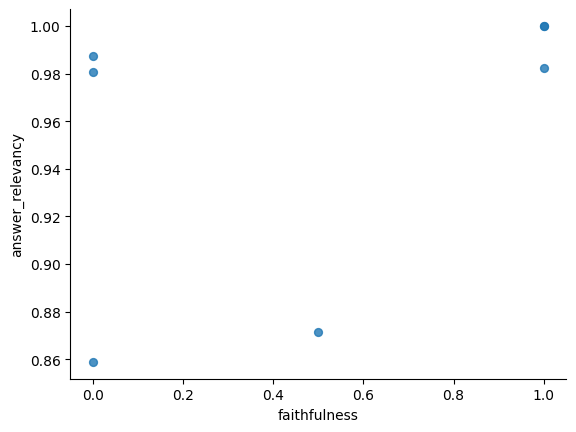

In [59]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='faithfulness', y='answer_relevancy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

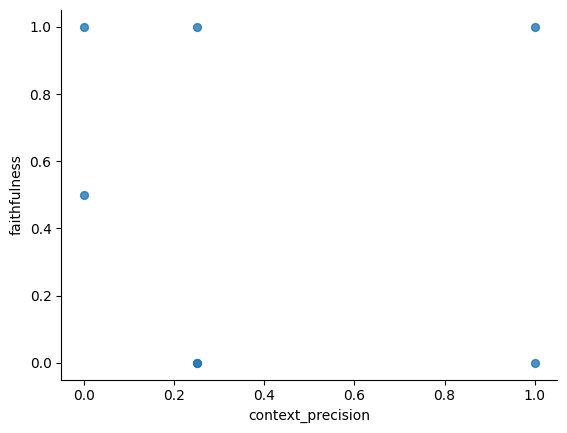

In [60]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='context_precision', y='faithfulness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

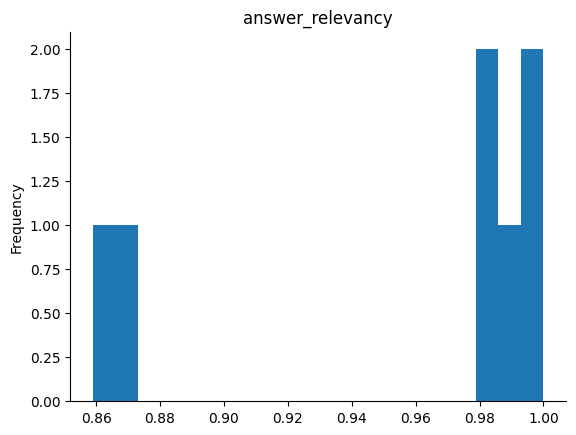

In [63]:
from matplotlib import pyplot as plt
df['answer_relevancy'].plot(kind='hist', bins=20, title='answer_relevancy')
plt.gca().spines[['top', 'right',]].set_visible(False)

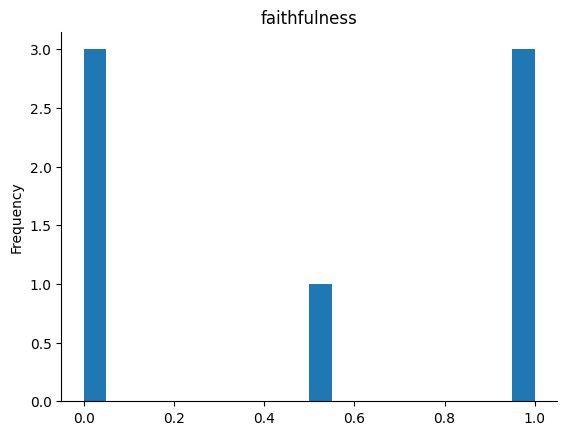

In [62]:
from matplotlib import pyplot as plt
df['faithfulness'].plot(kind='hist', bins=20, title='faithfulness')
plt.gca().spines[['top', 'right',]].set_visible(False)

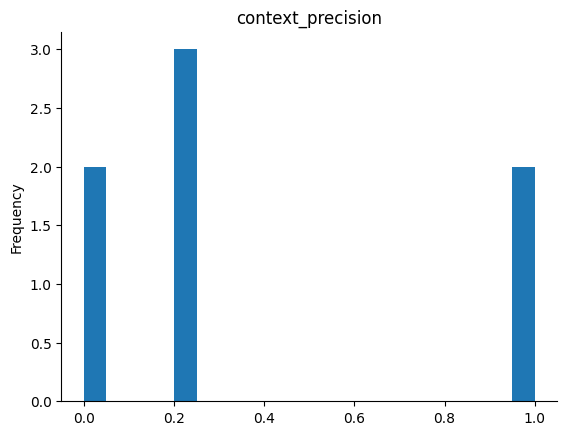

In [61]:
from matplotlib import pyplot as plt
df['context_precision'].plot(kind='hist', bins=20, title='context_precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Reranking the responses

In [46]:
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=Ensemble_ret
)
#
compressed_docs = compression_retriever.get_relevant_documents(query)
pretty_print_docs(compressed_docs)

Document 1:

Act).
“
Change
of
Control
Payment
”
means
(a)
any
bonus,
unfunded
severance
or
other 
payment
or
other
form
of
Compensation
that
is
created,
accelerated,
accrues
or
becomes
payable 
by
any
Acquired
Company
to
any
present
or
former
director ,
stockholder ,
employee,
consultant 
or
other
individual
service
provider
thereof,
including
pursuant
to
any
employment
agreement, 
benefit
plan
or
any
other
Contractual
Obligation,
including
the
employer
portion
of
any
Taxes 
payable
on
or
triggered
by
any
such
payment
----------------------------------------------------------------------------------------------------
Document 2:

Transaction
Expenses
”
means
all
costs,
fees
and
expenses
incurred
by
any 
Acquired
Company
or
any
Seller
in
connection
with
the
negotiation,
execution
and
delivery
of 
this
Agreement
and
the
Ancillary
Agreements
or
the
consummation
of
the
Contemplated 
Transactions,
to
the
extent
such
costs,
fees
and
expenses
are
payable
by
the
Buyer
at
Closing
or 
payable
o

In [47]:
#creating the prompt template
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Define LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Define prompt template
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use legal words only.
Answer according to the context given only and not what you know
Question: {question}
Context: {context}
Answer:
"""

prompt = ChatPromptTemplate.from_template(template)

# Setup RAG pipeline
rag_chain = (
    {"context": compression_retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser())

In [48]:
#evaluating the reranker
from datasets import Dataset
import pandas as pd

questions = ["Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?",
             "Does any of the Sellers provide a representation with respect to any Tax matters related to the Company?",
             "How much is the escrow amount?",
             "What is the purpose of the escrow?"
            ]
ground_truths = [["Except in the case of fraud, the Sellers have no liability for breach of representations and warranties "],
                ["No. Only the Company provides such a representation."],
                ["The escrow amount is equal to $1,000,000."],
                ["To serve as a recourse of the Buyer in case of post-closing adjustments of the purchase price."]]


answers = []
contexts = []

# Inference
for query in questions:
  answers.append(rag_chain.invoke(query))
  contexts.append([docs.page_content for docs in compression_retriever.get_relevant_documents(query)])

# To dict
data2 = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset2 = Dataset.from_dict(data)


In [49]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset1,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    raise_exceptions=False
)


df1= result.to_pandas()

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

In [58]:
df1

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent th...,The Sellers are responsible for any breach or ...,[based\non \nsuch\nadvice.\nEach\nSeller\nwill...,"[Except in the case of fraud, the Sellers have...","Except in the case of fraud, the Sellers have ...",0.25,1.0,0.0,0.856537
1,Does any of the Sellers provide a representati...,"Yes, the Sellers provide a representation with...","[on\nTax\nMatters\n.\nThe\nBuyer ,\nthe\nAcqui...",[No. Only the Company provides such a represen...,No. Only the Company provides such a represent...,0.25,1.0,0.0,0.980459
2,How much is the escrow amount?,"The escrow amount is $1,000,000.",[in\naccordance\nwith\nthe\nterms\nof \nthe\nE...,"[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",1.00,1.0,1.0,0.982516
3,Would the aggregate amount payable by the Buye...,"Yes, the aggregate amount payable by the Buyer...",[after\nthe\ncommencement\nof \nthe\nAccountin...,[yes],yes,1.00,1.0,0.0,0.984329
4,What is the purpose of the escrow?,The purpose of the escrow is to hold funds in ...,"[all\npurposes\nof\nthis\nAgreement,\nthe \nEs...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,0.00,1.0,1.0,1.000000
5,May the Escrow Amount serve as a recourse for...,Recovery from the Escrow Amount shall constitu...,[and\nthe\nEscrow\nAgent\n(in\naccordance\nwit...,[No],No,0.00,1.0,0.5,0.866566
6,Are Change of Control Payments considered a Se...,Change of Control Payments are not considered ...,"[Transaction\nExpenses\n”\nmeans\nall\ncosts,\...",[yes],yes,0.25,1.0,1.0,1.000000


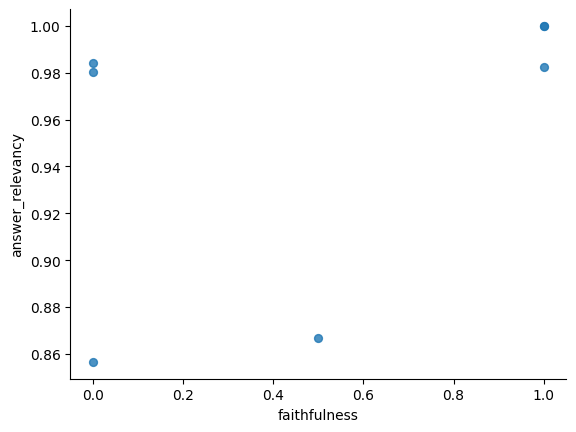

In [57]:
from matplotlib import pyplot as plt
df1.plot(kind='scatter', x='faithfulness', y='answer_relevancy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

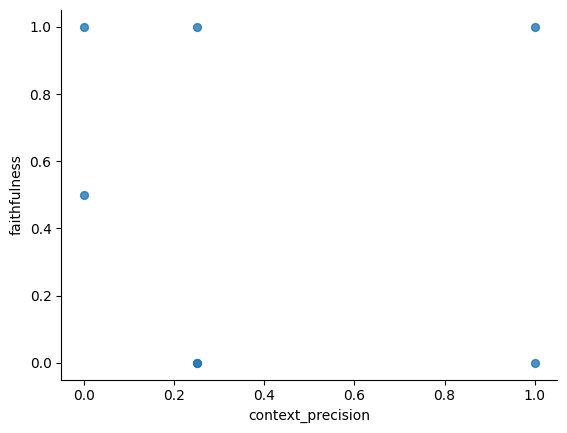

In [56]:
from matplotlib import pyplot as plt
df1.plot(kind='scatter', x='context_precision', y='faithfulness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

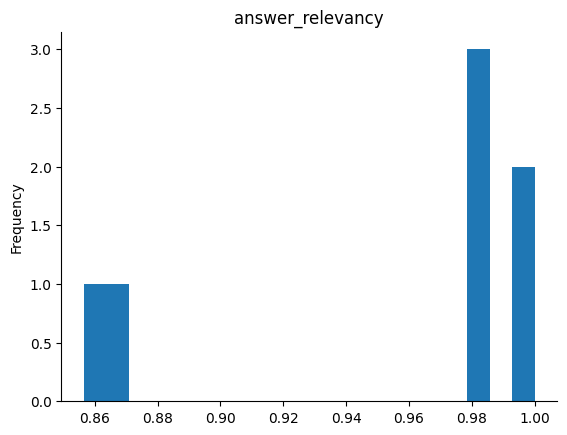

In [54]:
from matplotlib import pyplot as plt
df1['answer_relevancy'].plot(kind='hist', bins=20, title='answer_relevancy')
plt.gca().spines[['top', 'right',]].set_visible(False)

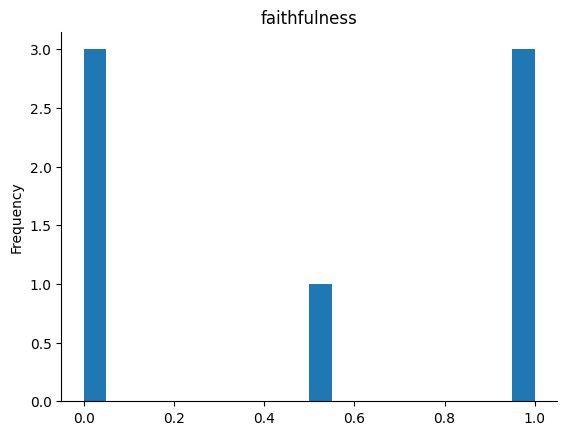

In [53]:
from matplotlib import pyplot as plt
df1['faithfulness'].plot(kind='hist', bins=20, title='faithfulness')
plt.gca().spines[['top', 'right',]].set_visible(False)

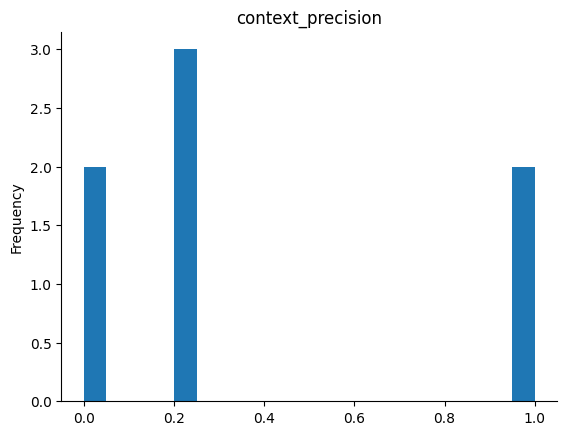

In [52]:
from matplotlib import pyplot as plt
df1['context_precision'].plot(kind='hist', bins=20, title='context_precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

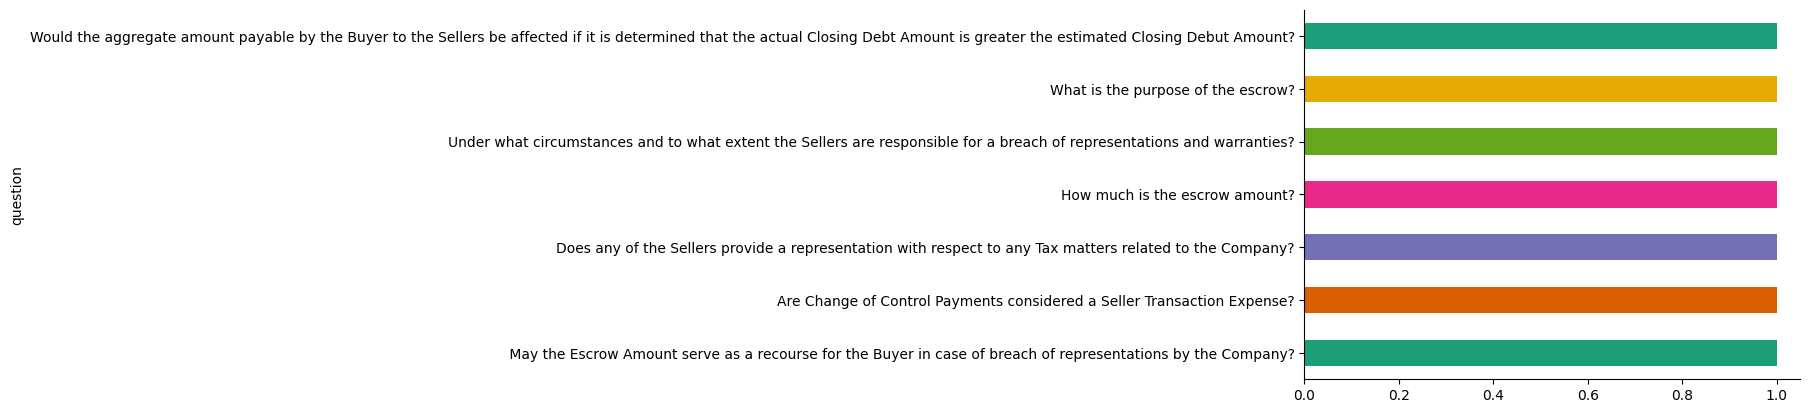

In [51]:
from matplotlib import pyplot as plt
import seaborn as sns
df1.groupby('question').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### rag fusion

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.prompts import ChatMessagePromptTemplate, PromptTemplate